In [359]:
import pandas as pd
import numpy as np
import yfinance as yf

# 獲取數據
data = pd.read_csv("./csv/interpolated_dataset.csv", parse_dates=["Date"])

# 提取收盤價
filtered_data = data[['Date','Tool','FPD','Temperature','RUL']]

In [360]:
data

,DateTime,Date,Tool,FPD,Temperature,RUL
0,2022-01-01,2022-01-01,A,0.620000,23.110000,0
1,2022-01-02,2022-01-02,A,0.655714,23.161429,0
2,2022-01-03,2022-01-03,A,0.691429,23.212857,0
3,2022-01-04,2022-01-04,A,0.727143,23.264286,0
4,2022-01-05,2022-01-05,A,0.762857,23.315714,0
...,...,...,...,...,...,...
5423,2024-12-24,2024-12-24,E,0.799091,23.592727,0
5424,2024-12-25,2024-12-25,E,0.811818,23.614545,0
5425,2024-12-26,2024-12-26,E,0.824545,23.636364,0
5426,2024-12-27,2024-12-27,E,0.837273,23.658182,0


In [361]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
filtered_data['RUL'] = scaler.fit_transform(filtered_data[['RUL']])

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_59403/3341726185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['RUL'] = scaler.fit_transform(filtered_data[['RUL']])


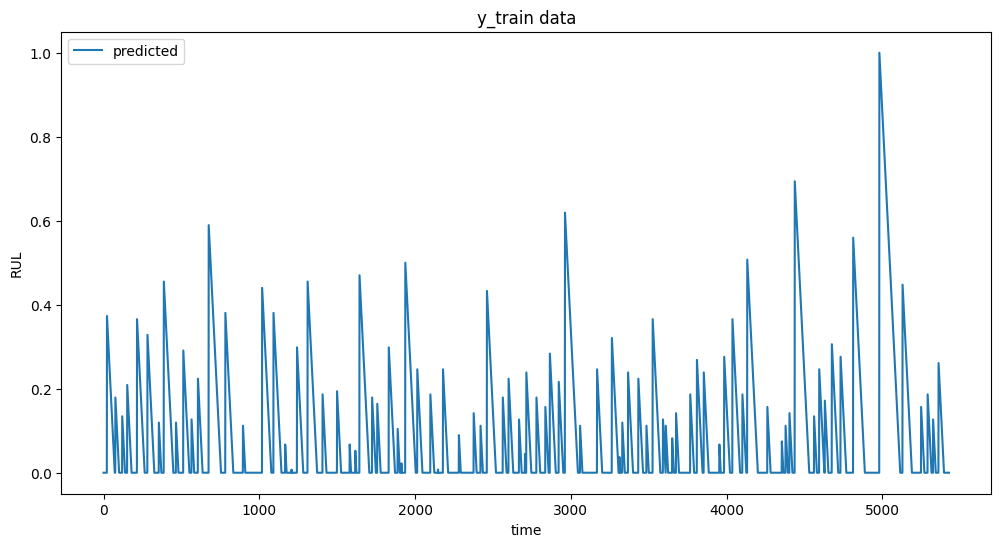

In [362]:
# visualize the filtered RUL data
plt.figure(figsize=(12,6))
plt.plot(filtered_data['RUL'], label='predicted')
plt.title('y_train data')
plt.xlabel('time')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [363]:
# 確保排序
filtered_data.sort_values(["Tool", "Date"], inplace=True, ignore_index=True)

# 參數設定
lookback = 30
train_tools = ["A", "B", "C", "D"]
test_tools  = ["E"]

# 你要拿哪些欄位當 X（多變量）
feature_cols = ["FPD", "Temperature"]   # 可依需求調整
# 你的 y（目標）。若要用 RUL 當 y，就寫 "RUL"
target_col = "RUL"

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_59403/3370562310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(["Tool", "Date"], inplace=True, ignore_index=True)


In [364]:
def build_sequences_per_tool(group_df: pd.DataFrame,
                             lookback: int,
                             feature_cols,
                             target_col):
    """
    對單一 Tool 的資料建立 sliding windows：
    - X：shape = (num_windows, lookback, feature_dim)
    - y：每個 window 的標籤取 window 末端（第 lookback 筆）的 target 值
    - 不跨 Tool 邊界
    """
    g = group_df.sort_values("Date")
    X_list, y_list = [], []

    feats = g[feature_cols].to_numpy()       # shape: (T, F)
    target = g[target_col].to_numpy()        # shape: (T,)

    T = len(g)
    if T < lookback:
        return None, None  # 這個 Tool 的資料不足以組成一個 window

    # 注意：最後一個 window 會是 (T - lookback) 起始於 0..(T-lookback)
    # 窗末端 index = i + lookback - 1
    for i in range(0, T - lookback + 1):
        x_win = feats[i:i+lookback]                    # (lookback, F)
        y_val = target[i + lookback - 1]               # 取 window 末端作為標籤
        X_list.append(x_win)
        y_list.append(y_val)

    X_arr = np.stack(X_list, axis=0)  # (N, lookback, F)
    y_arr = np.asarray(y_list)        # (N,)
    return X_arr, y_arr

X_train_list: [array([[[ 0.62      , 23.11      ],
        [ 0.65571429, 23.16142857],
        [ 0.69142857, 23.21285714],
        ...,
        [ 0.49142857, 22.55571429],
        [ 0.4725    , 22.51      ],
        [ 0.45357143, 22.46428571]],

       [[ 0.65571429, 23.16142857],
        [ 0.69142857, 23.21285714],
        [ 0.72714286, 23.26428571],
        ...,
        [ 0.4725    , 22.51      ],
        [ 0.45357143, 22.46428571],
        [ 0.43464286, 22.41857143]],

       [[ 0.69142857, 23.21285714],
        [ 0.72714286, 23.26428571],
        [ 0.76285714, 23.31571429],
        ...,
        [ 0.45357143, 22.46428571],
        [ 0.43464286, 22.41857143],
        [ 0.41571429, 22.37285714]],

       ...,

       [[ 0.4068    , 22.7164    ],
        [ 0.4156    , 22.7388    ],
        [ 0.4244    , 22.7612    ],
        ...,
        [ 0.75941176, 22.84647059],
        [ 0.77705882, 22.83235294],
        [ 0.79470588, 22.81823529]],

       [[ 0.4156    , 22.7388    ],
        [ 0.

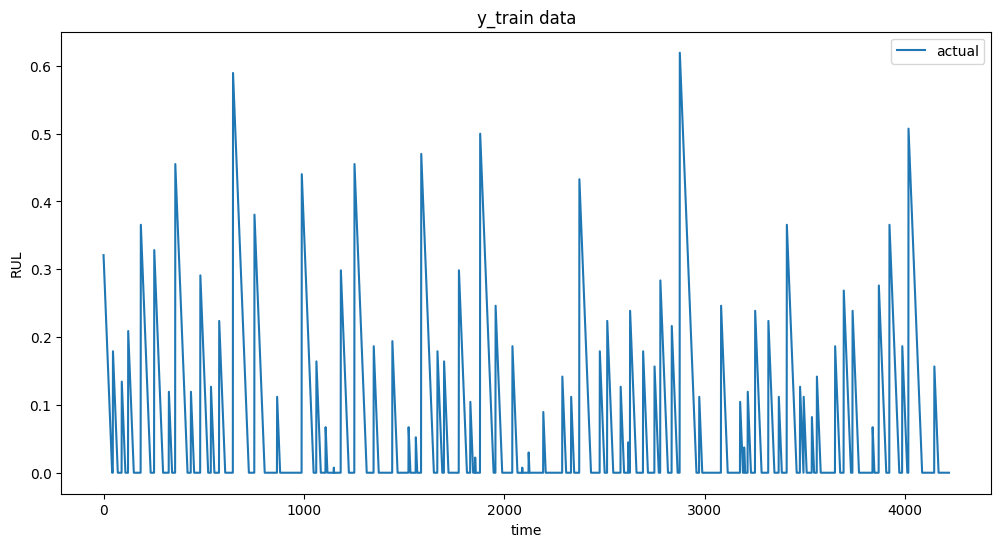

((4219, 30, 2), (4219,), (1064, 30, 2), (1064,))

In [365]:
def build_datasets_by_tool(df: pd.DataFrame,
                           train_tools, test_tools,
                           lookback: int,
                           feature_cols, target_col):
    # 先把需要的 Tool 篩出
    train_df = df[df["Tool"].isin(train_tools)].copy()
    test_df  = df[df["Tool"].isin(test_tools)].copy()

    # 逐 Tool 組 windows，最後再 concat
    X_train_list, y_train_list = [], []
    for tool, g in train_df.groupby("Tool"):
        out = build_sequences_per_tool(g, lookback, feature_cols, target_col)
        if out[0] is None:
            continue
        X_train_list.append(out[0])
        y_train_list.append(out[1])

    X_test_list, y_test_list = [], []
    for tool, g in test_df.groupby("Tool"):
        out = build_sequences_per_tool(g, lookback, feature_cols, target_col)
        if out[0] is None:
            continue
        X_test_list.append(out[0])
        y_test_list.append(out[1])
    # 串接所有 Tool 的 windows
    print("X_train_list:", X_train_list)
    X_train = np.concatenate(X_train_list, axis=0) if X_train_list else np.empty((0, lookback, len(feature_cols)))
    y_train = np.concatenate(y_train_list, axis=0) if y_train_list else np.empty((0,))

    X_test = np.concatenate(X_test_list, axis=0) if X_test_list else np.empty((0, lookback, len(feature_cols)))
    y_test = np.concatenate(y_test_list, axis=0) if y_test_list else np.empty((0,))

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = build_datasets_by_tool(
    filtered_data, train_tools, test_tools, lookback, feature_cols, target_col
)

# plot y_train
plt.figure(figsize=(12,6))
plt.plot(y_train, label='actual')
plt.title('y_train data')
plt.xlabel('time')
plt.ylabel('RUL')
plt.legend()
plt.show()

# 檢查一下形狀：
X_train.shape, y_train.shape, X_test.shape, y_test.shape

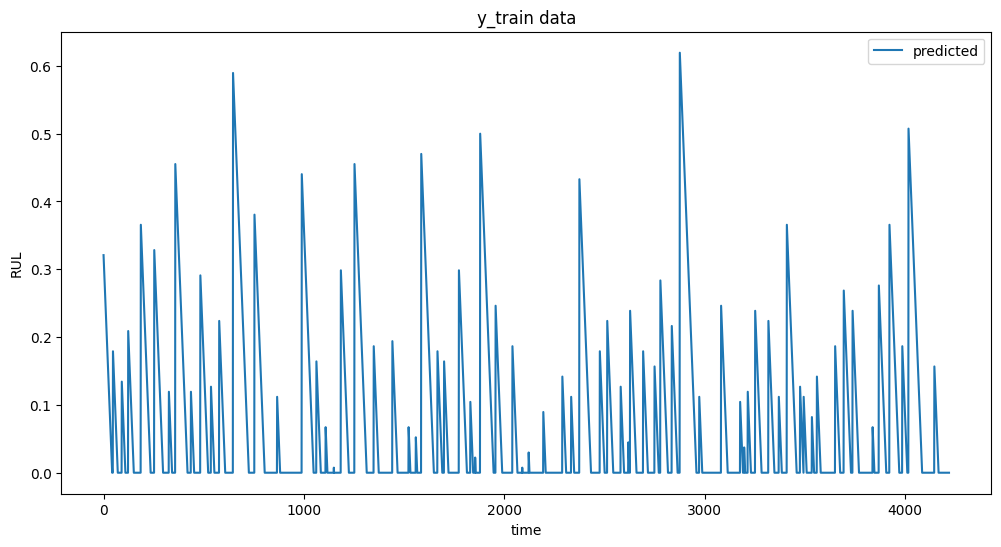

In [366]:
predicted = y_train

plt.figure(figsize=(12,6))
plt.plot(predicted, label='predicted')
plt.title('y_train data')
plt.xlabel('time')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [367]:
# 將數據轉換為 PyTorch 張量
import torch

# X: (N, L, F)
X_train_tensor = torch.from_numpy(X_train).float()     
X_test_tensor  = torch.from_numpy(X_test).float()

# y: (N,)
y_train_tensor = torch.from_numpy(y_train).float()
y_test_tensor  = torch.from_numpy(y_test).float()

# 若你的 Transformer 期望 (seq_len, batch, feature)

# print shapes
print("X_train_tensor.shape:", X_train_tensor.shape)
print("X_test_tensor.shape:", X_test_tensor.shape)


X_train_tensor.shape: torch.Size([4219, 30, 2])
X_test_tensor.shape: torch.Size([1064, 30, 2])


In [368]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用設備：{device}')

使用設備：cpu


In [369]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)  # (max_len, d_model)

    def forward(self, x):   # x: (B, T, H)
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)   # (1, T, H) → broadcast 成 (B, T, H)


In [370]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, nhead=4, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.input_linear = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim)

        encoder_layers = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 4,   # 常見做法：4×hidden_dim
            dropout=dropout,
            batch_first=True                  # ★ 關鍵，讓輸入 (B, T, F)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim

    def forward(self, src):                   # src: (B, T, F)
        src = self.input_linear(src)          # (B, T, H)
        src = self.pos_encoder(src)           # (B, T, H)
        output = self.transformer_encoder(src)  # (B, T, H)
        output = self.decoder(output[:, -1, :]) # 取最後一步 → (B, 1)
        return output


    def forward(self, src):
        # src 形狀: (seq_length, batch_size, feature_size)
        src = self.input_linear(src)  # 將輸入映射到 hidden_dim 維度
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # 取最後一個時間步的輸出
        output = self.decoder(output[-1, :, :])
        return output

In [371]:
feature_size = X_train_tensor.size(-1)
print("feature_size:", feature_size)
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeries(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim).to(device)

feature_size: 2


In [372]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [373]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [374]:
from torch.utils.data import TensorDataset, DataLoader
print("X_train_tensor.shape:", X_train_tensor.shape)
print("y_train_tensor.shape:", y_train_tensor.shape)
dataset = TensorDataset(X_train_tensor, y_train_tensor)        # X: (batch, seq, feat)
loader  = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze(-1)                           # (batch,)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # 驗證
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_tensor).squeeze(-1)
        val_loss = criterion(val_pred, y_test_tensor.to(device))
    print(f'Epoch {epoch+1}: train_loss={loss.item():.4f}, val_loss={val_loss.item():.4f}')


X_train_tensor.shape: torch.Size([4219, 30, 2])
y_train_tensor.shape: torch.Size([4219])


/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (30) must match the size of tensor b (32) at non-singleton dimension 0

In [ ]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反歸一化
# y_train_predict = scaler.inverse_transform(train_predict)
# y_train_actual = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
# y_test_predict = scaler.inverse_transform(test_predict)
# y_test_actual = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

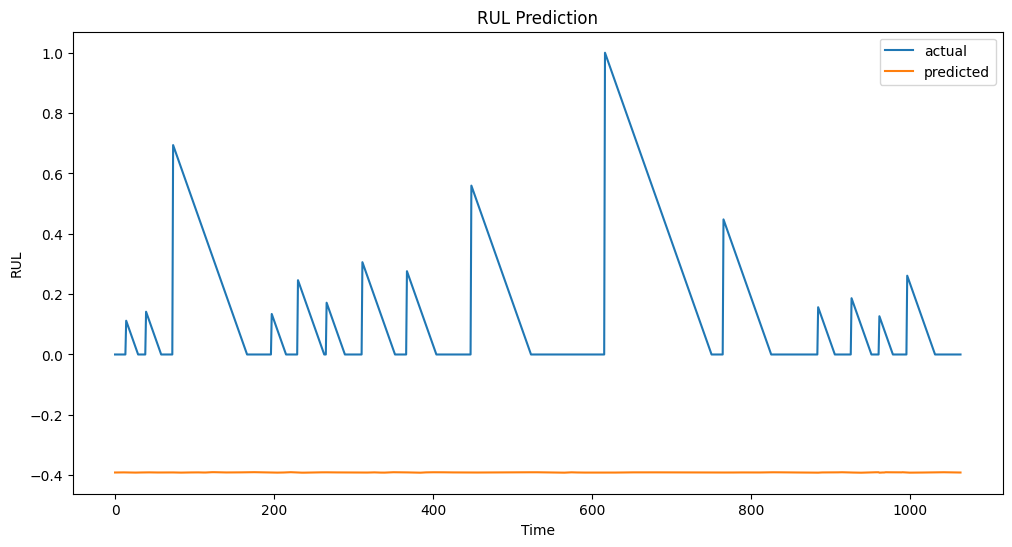

In [ ]:
import matplotlib.pyplot as plt

# 構建完整的時間序列
predicted = test_predict
actual = y_test_tensor.cpu().numpy()

plt.figure(figsize=(12,6))
plt.plot(actual, label='actual')
plt.plot(predicted, label='predicted')
plt.title('RUL Prediction')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

train_score = mean_squared_error(y_train_actual, train_predict)
test_score = mean_squared_error(y_test_actual, test_predict)
print(f'訓練集 MSE: {train_score:.2f}')
print(f'測試集 MSE: {test_score:.2f}')

訓練集 MSE: 6314142.00
測試集 MSE: 23465710.00
